# Collapsed Gibbs sampler for the finite IBP approximation

In [7]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
from copy import deepcopy

import VI_algorithms_lib
import valez_finite_VI_lib
from gibbs_sampler_lib import CollapsedGibbsSampler, display_results_Gibbs


## Draw data

In [8]:
# np.random.seed(5365) this seed works pretty well
np.random.seed(6874)

Num_samples = 500 # sample size
D = 2 # dimension
# so X will be a N\times D matrix

K_inf = 3 # take to be large for a good approximation to the IBP

alpha = 10 # IBP parameter

# Parameters to draw A from MVN
sigma_eps = .1 # variance of noise
sigma_A = 100

# generate data
Pi, Z, mu, A, X = valez_finite_VI_lib.generate_data(Num_samples, D, K_inf, sigma_A, sigma_eps, alpha)

K_approx = deepcopy(K_inf) # variational truncation


## Run collapsed Gibbs sampler

In [9]:
collapsed_GS = CollapsedGibbsSampler(X, K_approx, alpha, sigma_eps, sigma_A)

collapsed_GS.sample(100, 500)

N/A% (0 of 600) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Sampling:


100% (600 of 600) |#######################| Elapsed Time: 0:04:56 Time: 0:04:56


Done sampling :)


Z (unpermuted): 
 [[1 1 1]
 [1 1 1]
 [1 1 0]
 [1 1 1]
 [1 1 0]
 [1 1 1]
 [0 0 1]
 [1 1 1]
 [0 1 1]
 [1 0 1]]
** procedure did not give a true permutation
permutation:  [0 1 2]
Z (permuted) 
 [[1 1 1]
 [1 1 1]
 [1 1 0]
 [1 1 1]
 [1 1 0]
 [1 1 1]
 [0 0 1]
 [1 1 1]
 [0 1 1]
 [1 0 1]]
round_nu 
 [[ 1.  1.  0.]
 [ 1.  1.  0.]
 [ 1.  0.  0.]
 [ 1.  1.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  1.]
 [ 0.  1.  0.]
 [ 1.  0.  1.]
 [ 0.  1.  1.]
 [ 0.  1.  0.]]
l1 error (after permutation):  [0.16800000000000001, 0.51000000000000001, 0.34200000000000003]


true A (permuted): 
 [[  6.37166758  13.13405874]
 [ -4.78830387  15.3506954 ]
 [-16.17643427 -10.04860216]]
poster mean A: 
 [[ -2.27973953  19.04033338]
 [-11.43182625   0.72730305]
 [-11.42290453   0.79141425]]


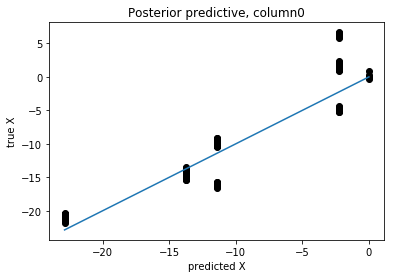

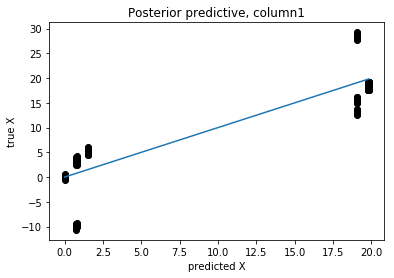

In [11]:
post_mean_Z = np.mean(collapsed_GS.z_draws, 0)
#post_mean_Z = collapsed_GS.z
tmp = np.dot(post_mean_Z.T, post_mean_Z) + sigma_eps/sigma_A * np.eye(K_approx)
mean_A = np.dot(np.linalg.solve(tmp, post_mean_Z.T), X)

display_results_Gibbs(X, Z, post_mean_Z, mean_A, A, manual_perm = None)

## Run VB

In [5]:
VI_instance = VI_algorithms_lib.VI_algorithms(X, K_approx, alpha, sigma_eps, sigma_A)

n_restart = 20
elbo_end = np.array([])

for i in range(n_restart): 
    VI_instance.re_init() # re initialize
    [tau_tmp, nu_tmp, phi_mu_tmp, phi_var_tmp, elbo] \
        = VI_instance.run_cavi_anneal(max_iter=500, tol=1e-6, verbose = False) # run cavi + annealing
        
    elbo_end = np.append(elbo_end, elbo[-1])
    
    # see if posterior predictive is better than all previous ones
    if (i == 0) or np.all(elbo_end[i] > elbo_end[:i]): 
        tau = deepcopy(tau_tmp)
        nu = deepcopy(nu_tmp)
        phi_mu = deepcopy(phi_mu_tmp)
        phi_var = deepcopy(phi_var_tmp)
    
    
print('max elbo: ', np.max(elbo_end))
print('average elbo', np.mean(elbo_end))

valez_finite_VI_lib.display_results(elbo, tau, nu, phi_mu, phi_var, X, Pi, Z, A)

TypeError: nu_updates() got an unexpected keyword argument 'anneal_temp'

In [ ]:
# compare results
VI_pred_X = np.dot(nu, phi_mu.T)
Gibbs_pred_X = np.dot(Z_Gibbs, mean_A)

for col in range(D):
    plt.clf()
    plt.plot(VI_pred_X[:, col], Gibbs_pred_X[:, col], 'ko')
    diag = np.linspace(np.min(VI_pred_X[:,col]),np.max(VI_pred_X[:,col]))
    plt.plot(diag,diag)
    
    plt.title('Posterior predictive, VB vs Gibbs, column' + str(col))
    plt.xlabel('VI_pred_X')
    plt.ylabel('Gibbs_pred_X')
    plt.show()


In [ ]:
def test_fun(x): 
    x[0] = x[0]+1 
    y = x ** 2
    return(y)

In [ ]:
x = np.array([2,3])
test_fun(x)
print(x)

In [ ]:
# posterior covariances of mu
# compare against truth
# rank 1 updates
# bigger data
# beta parameter type